In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from random import random

import colorsys
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib
from numpy import inf
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"

In [3]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-8]=0
    
    maps[behavior] = r_map

In [4]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 1#0.1#0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
vol = np.asarray(slices)
print(vol.shape)

(49, 128, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


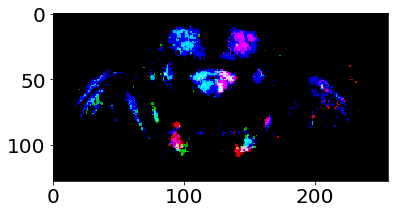

In [5]:
plt.imshow(vol[20,:,:,:]*20)

In [6]:
####################
### MAKE HSV VOL ###
####################

vol_flat = np.reshape(vol, (-1,3))
vol_flat = np.clip(vol_flat,0,1) # there are some negative corrs. remove these.
hsv_vol = []
to_delete = []
to_keep = []
for i in range(vol_flat.shape[0]):
    if np.sum(vol_flat[i]) != 0: # exclude black pixels (0,0,0)
        hsv_vol.append(colorsys.rgb_to_hsv(*vol_flat[i]))
        to_keep.append(i)
    else:
        to_delete.append(i)
hsv_vol = np.asarray(hsv_vol)

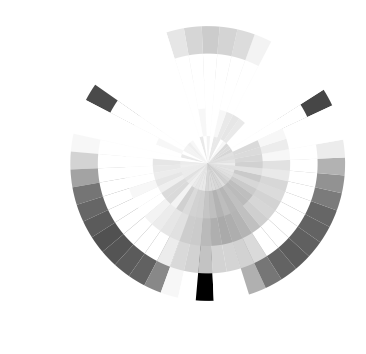

In [7]:
cm_grey = matplotlib.cm.get_cmap('Greys')
cm_hsv = matplotlib.cm.get_cmap('hsv')


patches = []
values = []

rotation = 25

ntheta = 48; dtheta = 360/ntheta;
nradius = 5; dradius = 10/nradius;

colors = np.linspace(0,255,ntheta+1)
colors = [int(i) for i in colors]

saturations = np.linspace(0,1,nradius)

#####################
### Make Hue Bins ###
#####################

hue_bin_centers = [i/255 for i in colors]
bin_width = hue_bin_centers[1] - hue_bin_centers[0]

# hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
# hue_bin_ends = np.delete(hue_bin_starts,0).extend(1)
#hue_bin_ends = [i+bin_width/2 for i in hue_bin_centers]
# deal with wrapping red around zero
# hue_bin_starts[0] = 0
# hue_bin_ends[-1] = 1

hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
hue_bin_starts[0] = 0
hue_bin_ends = list(np.delete(hue_bin_starts,0))
hue_bin_ends.append(1)

#####################
### Make Sat Bins ###
#####################
sat_bin_starts = [.8,.6,.4,.2,0]
sat_bin_ends = [1,.8,.6,.4,.2]

##############################
### Get Hue/Sat Bin Counts ###
##############################

bin_cnts = []

for sat_bn in range(len(sat_bin_starts)):
    sat_bin = np.where(np.logical_and(sat_bin_starts[sat_bn]<hsv_vol[:,1],
                              hsv_vol[:,1]<=sat_bin_ends[sat_bn]))[0]
    for hue_bn in range(len(hue_bin_starts)):
        hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_vol[:,0],
                                          hsv_vol[:,0]<hue_bin_ends[hue_bn]))[0]
        bin_cnts.append(len(set(hue_bin) & set(sat_bin)))

### Log transform ###
bin_cnts_log = np.log(bin_cnts)
bin_cnts_log[bin_cnts_log==-inf]=0
        
bin_cnts_max = np.max(bin_cnts_log) ### ADJUST THIS TO CLIP
bin_cnts_norm = [i/bin_cnts_max for i in bin_cnts_log]

cnt = 0
for nr in range(nradius,0,-1):
    start_r = (nr-1)*dradius
    end_r = (nr)*dradius
    for nt in range(0,ntheta):
        start_t = nt*dtheta
        end_t = (nt+1)*dtheta
        if nr == 6:
            values.append(cm_hsv(int(nt*(255/ntheta))))
        else:
            values.append(cm_grey(bin_cnts_norm[cnt]))
            cnt+=1
        
        wedge = mpatches.Wedge(0,end_r, start_t+rotation, end_t+rotation)
        patches.append(wedge)
        
        
collection = PatchCollection(patches,linewidth=0,
edgecolor=['#000000' for x in values], 
facecolor=values)

fig = plt.figure(figsize=(10,10), edgecolor='w',facecolor='w')
ax = plt.subplot(2, 2, 1)
ax.add_collection(collection)

plt.axis('equal')
plt.axis('off')
plt.tight_layout()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [8]:
red_cnt = bin_cnts[0]
green_cnt = bin_cnts[16]
blue_cnt = bin_cnts[32]

rg_cnt = np.sum(bin_cnts[1:16])
gb_cnt = np.sum(bin_cnts[17:32])
br_cnt = np.sum(bin_cnts[33:48])
rgb_cnt = np.sum(bin_cnts[49:])

In [9]:
print(
    red_cnt, 
    green_cnt,
    blue_cnt,
    rg_cnt,
    gb_cnt,
    br_cnt,
    rgb_cnt
     )
print(red_cnt+green_cnt+blue_cnt+rg_cnt+gb_cnt+br_cnt+rgb_cnt)
print(hsv_vol.shape)
print(len(hue_bin_starts))

4416 3856 45407 85 14707 10079 1997
80547
(80547, 3)
49


In [10]:
sat_bin = np.where(np.logical_and(.8<hsv_vol[:,1],hsv_vol[:,1]<=1))

hue_bn=0 # red
#hue_bn=16 # green
hue_bn=32 # blue

hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_vol[:,0],
            hsv_vol[:,0]<hue_bin_ends[hue_bn]))

isolated_voxels = set(hue_bin[0]) & set(sat_bin[0])
isolated_voxels = list(isolated_voxels)
len(isolated_voxels)

45407

In [11]:
# YELLOW #
sat_bin = np.where(np.logical_and(.8<hsv_vol[:,1],hsv_vol[:,1]<=1))

#hue_bn=0 # red
hue_bn=16 # green
hue_bn=32 # blue

hue_bin = np.where(np.logical_and(hue_bin_starts[1]<=hsv_vol[:,0],
            hsv_vol[:,0]<hue_bin_ends[15]))

isolated_voxels = set(hue_bin[0]) & set(sat_bin[0])
isolated_voxels = list(isolated_voxels)
len(isolated_voxels)

85

In [12]:
# CYAN #
sat_bin = np.where(np.logical_and(.8<hsv_vol[:,1],hsv_vol[:,1]<=1))

#hue_bn=0 # red
hue_bn=16 # green
hue_bn=32 # blue

hue_bin = np.where(np.logical_and(hue_bin_starts[17]<=hsv_vol[:,0],
            hsv_vol[:,0]<hue_bin_ends[31]))

isolated_voxels = set(hue_bin[0]) & set(sat_bin[0])
isolated_voxels = list(isolated_voxels)
len(isolated_voxels)

14707

In [13]:
# MAGENTA #
sat_bin = np.where(np.logical_and(.8<hsv_vol[:,1],hsv_vol[:,1]<=1))

#hue_bn=0 # red
hue_bn=16 # green
hue_bn=32 # blue

hue_bin = np.where(np.logical_and(hue_bin_starts[33]<=hsv_vol[:,0],
            hsv_vol[:,0]<hue_bin_ends[47]))

isolated_voxels = set(hue_bin[0]) & set(sat_bin[0])
isolated_voxels = list(isolated_voxels)
len(isolated_voxels)

10079

In [14]:
# WHITE #
sat_bin = np.where(.8>hsv_vol[:,1])[0]

#hue_bn=0 # red
# hue_bn=16 # green
# hue_bn=32 # blue
#hue_bin = np.where(hue_bin_starts[49]<=hsv_vol[:,0])

#isolated_voxels = set(hue_bin[0]) & set(sat_bin[0])
isolated_voxels = list(sat_bin)
len(isolated_voxels)

1997

In [15]:
### This one is right ###

empty = np.zeros(len(to_keep))
empty[isolated_voxels] = 1
full_vol = np.zeros(len(to_keep)+len(to_delete))
full_vol[to_keep] = empty
to_plot = np.reshape(full_vol, (49,128,256))

In [16]:
to_plot.shape

(49, 128, 256)

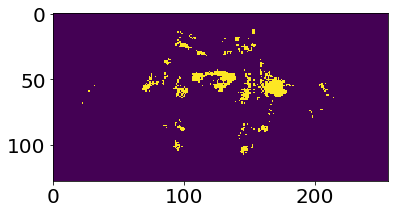

In [17]:
plt.imshow(np.max(to_plot,axis=0))

# Warp and explode

In [18]:
# want (256, 128, 49)
to_plot = np.swapaxes(to_plot,0,2)
to_plot.shape

(256, 128, 49)

In [19]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [20]:
moving = ants.from_numpy(to_plot[:,:,::-1])
moving.set_spacing((2.6076, 2.6154, 5.3125)) ### matching this to the slightly off luke mean

In [21]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [22]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], interpolator='nearestNeighbor')

In [23]:
isolated_map = maps_voxel_res.numpy()

In [24]:
isolated_map.shape

(314, 146, 91)

In [150]:
isolated_map_magenta = isolated_map.copy()

In [36]:
empty = np.zeros(isolated_map.shape)
to_plot = np.stack((isolated_map,isolated_map,isolated_map),axis=3)
to_plot.shape

(314, 146, 91, 3)

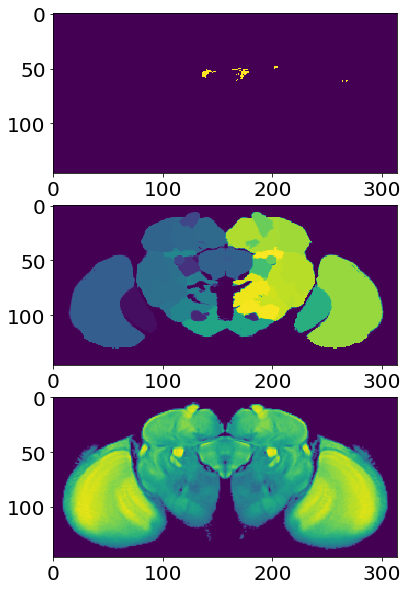

In [25]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(isolated_map[:,:,z].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

(-0.5, 313.5, 145.5, -0.5)

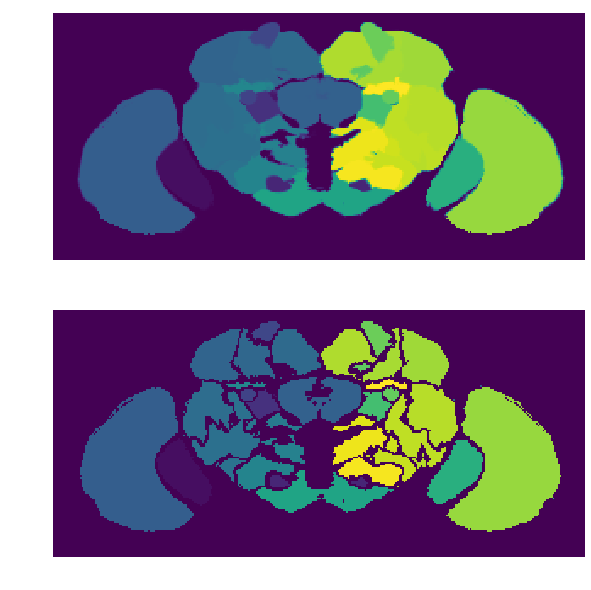

In [26]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [34]:
### ONE COLOR ###

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*isolated_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [37]:
### 3 COLOR ###

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        masked_roi = mask_dilated[...,np.newaxis]*to_plot

#         # for plotting
#         left_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0])
#         right_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1])
#         top_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0])
#         bottom_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1])

        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)

        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*10#*10000#*20 #here

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

In [31]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


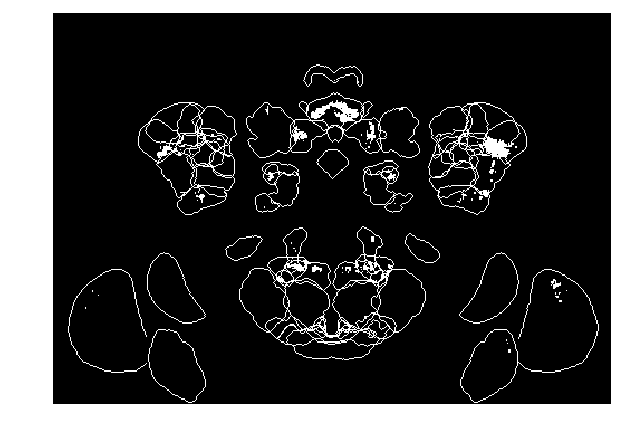

In [39]:
#input_canvas = np.zeros((500,500))
input_canvas = np.zeros((500,500,3))


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight', transparent=True)

# Quantify

In [48]:
##################
### ROI GROUPS ###
##################

full_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L',
6: 'PB',
23: 'EB',
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L',
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',#####
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L',
}

In [49]:
roi_counts = {}
for roi in full_group.keys():
    ############ Get voxels in ROI #############

    ### Get list of voxels in ROI in RGB
    mask = np.zeros(atlas_clean.shape)
    mask[np.where(atlas_clean == roi)] = 1
    mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)
    roi_voxels = corr_map[np.where(mask_dilated == 1)]

    ### Convert list to HSV
    hsv_voxels = []
    blk_cnt=0
    for i in range(roi_voxels.shape[0]):
        if np.sum(roi_voxels[i]) != 0: # exclude black pixels (0,0,0)
            hsv_voxels.append(colorsys.rgb_to_hsv(*roi_voxels[i]))
        else:
            blk_cnt +=1
    hsv_voxels = np.asarray(hsv_voxels)

    ############## PUT IN BINS ###############

    ntheta = 48; dtheta = 360/ntheta;
    nradius = 5; dradius = 10/nradius;

    colors = np.linspace(0,255,ntheta+1)
    colors = [int(i) for i in colors]

    #####################
    ### Make Hue Bins ###
    #####################

    hue_bin_centers = [i/255 for i in colors]
    bin_width = hue_bin_centers[1] - hue_bin_centers[0]
    hue_bin_starts = [i-bin_width/2 for i in hue_bin_centers]
    hue_bin_starts[0] = 0
    hue_bin_ends = list(np.delete(hue_bin_starts,0))
    hue_bin_ends.append(1)

    #####################
    ### Make Sat Bins ###
    #####################
    sat_bin_starts = [.8,.6,.4,.2,0]
    sat_bin_ends = [1,.8,.6,.4,.2]

    ##############################
    ### Get Hue/Sat Bin Counts ###
    ##############################

    bin_cnts = []

    for sat_bn in range(len(sat_bin_starts)):
        sat_bin = np.where(np.logical_and(sat_bin_starts[sat_bn]<hsv_voxels[:,1],
                                  hsv_voxels[:,1]<=sat_bin_ends[sat_bn]))[0]
        for hue_bn in range(len(hue_bin_starts)):
            hue_bin = np.where(np.logical_and(hue_bin_starts[hue_bn]<=hsv_voxels[:,0],
                                              hsv_voxels[:,0]<hue_bin_ends[hue_bn]))[0]
            bin_cnts.append(len(set(hue_bin) & set(sat_bin)))

    ################ Get bin counts #################
    red_cnt = bin_cnts[0]
    green_cnt = bin_cnts[16]
    blue_cnt = bin_cnts[32]
    rg_cnt = np.sum(bin_cnts[1:16])
    gb_cnt = np.sum(bin_cnts[17:32])
    br_cnt = np.sum(bin_cnts[33:48])
    rgb_cnt = np.sum(bin_cnts[49:])
    
#     roi_counts[roi] = [red_cnt, green_cnt, blue_cnt,
#                        rg_cnt, gb_cnt, br_cnt,
#                        rgb_cnt, blk_cnt]
    
    roi_counts[roi] = [red_cnt, br_cnt, blue_cnt, gb_cnt, green_cnt, rg_cnt, rgb_cnt, blk_cnt]

NameError: name 'corr_map' is not defined